In [27]:
import re
import spacy
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from string import punctuation
from wordcloud import WordCloud, STOPWORDS

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords


sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from nltk import bigrams
import pickle

import os
import gensim

from pprint import pprint

import matplotlib.colors as mcolors
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
from collections import Counter
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud 
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
 
from operator import itemgetter
 
WNL = nltk.WordNetLemmatizer()

In [28]:
survey = pd.read_csv("/Users/swagyangjh/Desktop/Processed_survey.csv")

In [29]:
sent_topics_sorteddf_mallet = pd.DataFrame()
df_dominant_topic = pd.DataFrame()
vis = 0

In [30]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('[,\.!?]', '', sent)  # remove emails
        sent = sent.lower()  
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

In [31]:
# structure the main topic
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp[:10]])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,10), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [32]:
def ngrams(tokens, n):
    # Returns all ngrams of size n in sentence, where an ngram is itself a list of tokens
    temp=zip(*[tokens[i:] for i in range(0,n)])
    ans=[' '.join(n) for n in temp]
    ans = [k.split(' ') for k in ans]
    return ans

In [58]:
def QA(datasetnum,method_justification):

    # Dataset
    dataset = survey.loc[survey['Dataset']==datasetnum]

    # Jusitification
    justification = dataset[method_justification]
    justification
    clean_justification = justification.dropna(axis=0,how='all')  
    clean_justification = clean_justification[:]
    clean_justification.head()

    # Stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'image','edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'rather', 'lot', 'make', 'want', 'seem', 'run', 'need', 'even', 'even', 'also', 'may', 'take', 'come'])
    stop_words.extend(["patients", "floor", "icu","alive","discharged", "er", 'two','three'])


    data = clean_justification.tolist()

    data_words = list(sent_to_words(data))

    # Remove Stop Words
    sentences=[]
    for line in data_words:
        try:
            segs = [i for i in line if i not in stop_words]
            sentences.append(segs)
        except:
            print (line)
            continue
    bigram = []
    for i,j in enumerate(sentences):
        bigrams = ngrams(sentences[i],2)
        bigram.append(bigrams)
        
    bigram_string = []
    for i in range(len(bigram)):
        #for j in range(len(bigram[i])):
        bigram_string.extend(bigram[i])       
        

    # Create Dictionary
    id2word = Dictionary(bigram_string)

    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in bigram_string]

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=2, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=10,
                                               passes=10,
                                               alpha='symmetric',
                                               iterations=100,
                                               per_word_topics=True)




    df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=bigram_string)

    # Format
    global df_dominant_topic
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    #print(df_dominant_topic.head(10))

    """get samples of sentences that most represent a given topic."""
    global sent_topics_sorteddf_mallet
    pd.options.display.max_colwidth = 100

    sent_topics_sorteddf_mallet = pd.DataFrame()
    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
        sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                                 grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                                axis=0)
    
    # Reset Index    
    sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

    # Format
    sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

    # Show
    #print(sent_topics_sorteddf_mallet.head(10))

    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

#     # Initialise the count vectorizer with the English stop words
#     count_vectorizer = CountVectorizer(stop_words='english')
#     # Fit and transform the processed titles
#     count_data = count_vectorizer.fit_transform(clean_justification)
#     # Visualise the 10 most common words
#     plot_10_most_common_words(count_data, count_vectorizer)


#     new_text = df_dominant_topic[["Keywords","Text"]].apply(lambda x:word_drop_keywords(x),axis=1)
#     new_text = [i for i in new_text if len(i) >0]
#     new_data = [" ".join(i) for i in new_text ]
    pyLDAvis.enable_notebook()
    global vis
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    



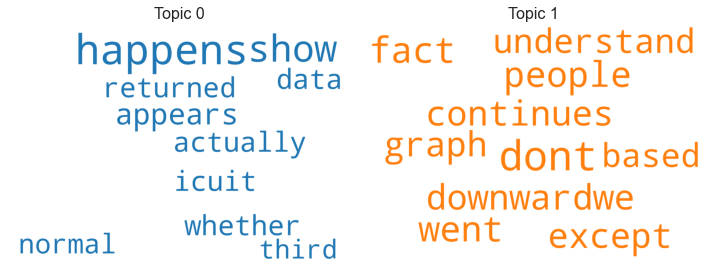

/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [59]:
dataset0 = QA('0','cf_Justification')

In [60]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.832166,"happens, show, appears, whether, data, icuit, actually, returned, normal, third","[show, happens]"
1,1.0,0.832193,"dont, fact, people, went, downwardwe, continues, except, graph, understand, based","[fact, fact]"


In [61]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.810424,"dont, fact, people, went, downwardwe, continues, except, graph, understand, based","[seems, fairly]"
1,1,1.0,0.817202,"dont, fact, people, went, downwardwe, continues, except, graph, understand, based","[fairly, simple]"
2,2,1.0,0.781276,"dont, fact, people, went, downwardwe, continues, except, graph, understand, based","[simple, branches]"
3,3,1.0,0.832050,"dont, fact, people, went, downwardwe, continues, except, graph, understand, based","[easy, understand]"
4,4,1.0,0.832028,"dont, fact, people, went, downwardwe, continues, except, graph, understand, based","[understand, went]"
5,5,1.0,0.796149,"dont, fact, people, went, downwardwe, continues, except, graph, understand, based","[went, got]"
6,6,0.0,0.797399,"happens, show, appears, whether, data, icuit, actually, returned, normal, third","[got, facts]"
7,7,1.0,0.506870,"dont, fact, people, went, downwardwe, continues, except, graph, understand, based","[facts, shown]"
8,8,1.0,0.780663,"dont, fact, people, went, downwardwe, continues, except, graph, understand, based","[quality, okay]"
9,9,1.0,0.798423,"dont, fact, people, went, downwardwe, continues, except, graph, understand, based","[okay, last]"


In [62]:
vis

PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
1      0.115909  0.0       1        1  53.84997
0     -0.115909  0.0       2        1  46.15003, topic_info=            Term      Freq     Total Category  logprob  loglift
78       happens  9.000000  9.000000  Default  30.0000  30.0000
121         show  8.000000  8.000000  Default  29.0000  29.0000
92          dont  7.000000  7.000000  Default  28.0000  28.0000
13          fact  6.000000  6.000000  Default  27.0000  27.0000
126      appears  4.000000  4.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
131      exactly  2.514210  5.545725   Topic2  -4.1337  -0.0178
120        alone  2.208896  4.600454   Topic2  -4.2632   0.0396
112      certain  1.925318  3.842212   Topic2  -4.4006   0.0823
118     previous  1.850876  3.852276   Topic2  -4.4400   0.0403
73   information  1.767734  3.448816   Topic2  -4.4860   0.1049

[103 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
116       1  0.272063        able
116       2  0.816190        able
24        1  1.005263  activities
124       1  0.228168    actually
124       2  0.912671    actually
...     ...       ...         ...
109       2  0.522717  visualized
6         1  0.862399        went
122       1  0.228228     whether
122       2  0.912914     whether
105       2  0.756150       wrong

[89 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])